# Movie Recommendation System

## Introduction

This notebook analyzes MovieLens dataset and wiki movie plots to build a recommendation system. It performs the following tasks:
1. Find and print top-5 genres based on average movie rating
2. Suggest five movies to a new user
3. Add new user ratings to the dataset
4. Use Stochastic Gradient Descent (SGD) for personalized recommendations
5. Use TF-IDF vectorizer for content-based recommendations based on movie plots

## Setup and Data Loading

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import re
import warnings

warnings.filterwarnings('ignore')

movies_file = 'movies.dat'
ratings_file = 'ratings.dat'
tags_file = 'tags.dat'
plots_file = 'wiki_movie_plots_deduped.csv' 

In [22]:
# For MovieLens 1M format - adjust delimiter and column names based on your dataset
def load_movielens_dat(file_path, columns):
    # MovieLens 1M format uses '::' as separator
    try:
        return pd.read_csv(file_path, sep='::', names=columns, encoding='latin-1', engine='python')
    except:
        # Try alternative formats if the standard format fails
        try:
            return pd.read_csv(file_path, sep=',', names=columns, encoding='latin-1')
        except:
            try:
                return pd.read_csv(file_path, sep='\t', names=columns, encoding='latin-1')
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
                return None

# Load the datasets
try:
    movies = load_movielens_dat(movies_file, ['MovieID', 'Title', 'Genres'])
    ratings = load_movielens_dat(ratings_file, ['UserID', 'MovieID', 'Rating', 'Timestamp'])
    tags = load_movielens_dat(tags_file, ['UserID', 'MovieID', 'Tag', 'Timestamp'])
    
    # For the wiki movie plots dataset (CSV format with headers)
    # Adjust column names if needed based on actual file structure
    try:
        plots_df = pd.read_csv(plots_file)
    except:
        try:
            plots_df = pd.read_csv(plots_file, sep='\t')
        except Exception as e:
            print(f"Error loading plots file: {e}")
            plots_df = None
            
    # Display basic information about the datasets
    print("Movies dataset shape:", movies.shape if movies is not None else "Failed to load")
    print("Ratings dataset shape:", ratings.shape if ratings is not None else "Failed to load")
    print("Tags dataset shape:", tags.shape if tags is not None else "Failed to load")
    print("Plots dataset shape:", plots_df.shape if plots_df is not None else "Failed to load")
    
    # Display sample data
    if movies is not None:
        print("\nFirst 5 rows of movies dataset:")
        display(movies.head())
    
    if ratings is not None:
        print("\nFirst 5 rows of ratings dataset:")
        display(ratings.head())
    
    if plots_df is not None:
        print("\nFirst 5 rows of plots dataset:")
        display(plots_df.head())
        
except Exception as e:
    print(f"An error occurred during data loading: {e}")

Movies dataset shape: (10681, 3)
Ratings dataset shape: (10000054, 4)
Tags dataset shape: (95580, 4)
Plots dataset shape: (34886, 8)

First 5 rows of movies dataset:


,MovieID,Title,Genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



First 5 rows of ratings dataset:


,UserID,MovieID,Rating,Timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392



First 5 rows of plots dataset:


,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


## Task 1: Find Top-5 Genres Based on Average Movie Rating

Top 5 genres based on average movie rating:


,Genre,Average Rating,Rating Count
4,Film-Noir,4.012151,131592
12,Documentary,3.783459,103454
18,War,3.780173,568063
6,IMAX,3.764537,9080
10,Mystery,3.677631,630944


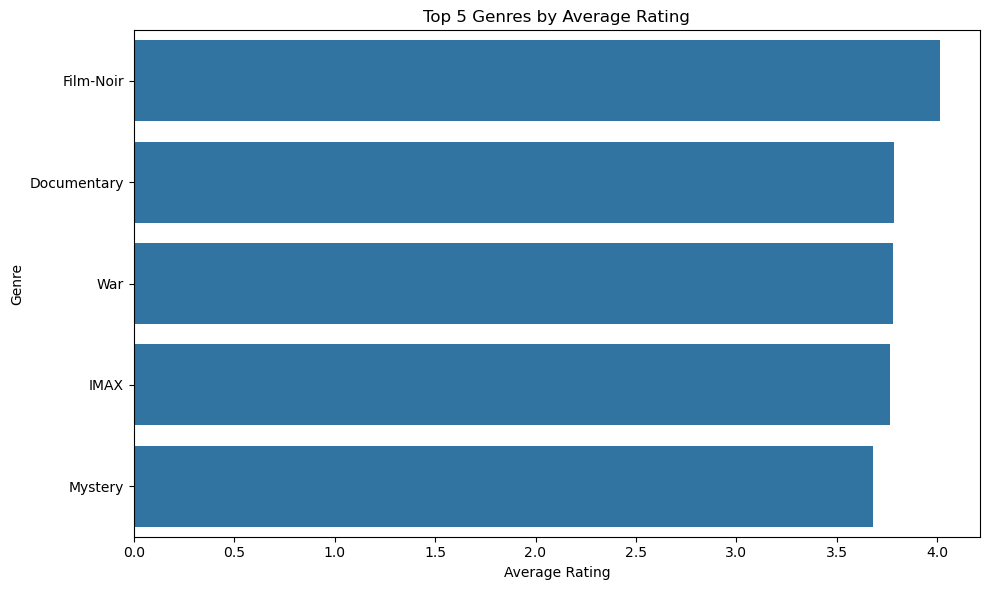

In [4]:
def get_top_genres(movies_df, ratings_df, top_n=5):
    """
    Find the top N genres based on average movie rating.
    """
    # Merge ratings with movies
    movie_ratings = pd.merge(ratings_df, movies_df, on='MovieID')
    
    # Create a list of all genres
    all_genres = []
    for genre_list in movies_df['Genres'].str.split('|'):
        all_genres.extend(genre_list)
    
    unique_genres = set(all_genres)
    
    # Calculate average rating for each genre
    genre_ratings = []
    for genre in unique_genres:
        # Filter movies that belong to this genre
        genre_movies = movie_ratings[movie_ratings['Genres'].str.contains(genre)]
        avg_rating = genre_movies['Rating'].mean()
        count = genre_movies.shape[0]
        genre_ratings.append({
            'Genre': genre,
            'Average Rating': avg_rating,
            'Rating Count': count
        })
    
    # Convert to DataFrame and sort by average rating
    genre_df = pd.DataFrame(genre_ratings)
    top_genres = genre_df.sort_values(by='Average Rating', ascending=False).head(top_n)
    
    return top_genres

# Find top genres
top_genres = get_top_genres(movies, ratings)
print("Top 5 genres based on average movie rating:")
display(top_genres)

# Visualize the top genres
plt.figure(figsize=(10, 6))
sns.barplot(x='Average Rating', y='Genre', data=top_genres)
plt.title('Top 5 Genres by Average Rating')
plt.tight_layout()
plt.show()

## Task 2: Suggest Five Movies to a New User

In [23]:
def get_diverse_top_rated_movies(movies_df, ratings_df, min_ratings=100, top_n=5):
    # Calculate average rating and count for each movie
    movie_stats = ratings_df.groupby('MovieID').agg({
        'Rating': ['mean', 'count']
    }).reset_index()
    movie_stats.columns = ['MovieID', 'Average_Rating', 'Rating_Count']
    
    # Filter movies with at least min_ratings
    popular_movies = movie_stats[movie_stats['Rating_Count'] >= min_ratings]
    
    # Merge with movie details to get genre information
    popular_movies_with_info = pd.merge(popular_movies, movies_df, on='MovieID')
    
    # Sort by average rating
    sorted_movies = popular_movies_with_info.sort_values(by='Average_Rating', ascending=False)
    
    # Take the overall top-rated movie as the first recommendation
    recommendations = [sorted_movies.iloc[0]]
    
    # Track genres we've already included
    included_genres = set()
    for genre in recommendations[0]['Genres'].split('|'):
        included_genres.add(genre)
    
    # For remaining slots, prioritize different genres
    remaining_movies = sorted_movies.iloc[1:].copy()
    
    while len(recommendations) < top_n and not remaining_movies.empty:
        # Calculate a diversity score for each movie
        diversity_scores = []
        
        for idx, movie in remaining_movies.iterrows():
            movie_genres = set(movie['Genres'].split('|'))
            # Count how many new genres this movie would add
            new_genres_count = len(movie_genres - included_genres)
            # Diversity score combines rating and new genres
            # You can adjust the weighting based on how much you value diversity vs. rating
            diversity_score = 0.1 * movie['Average_Rating'] + 0.9 * new_genres_count
            diversity_scores.append((idx, diversity_score))
        
        # Sort by diversity score
        diversity_scores.sort(key=lambda x: x[1], reverse=True)
        
        # Add the most diverse high-rated movie
        best_idx = diversity_scores[0][0]
        best_movie = remaining_movies.loc[best_idx]
        recommendations.append(best_movie)
        
        # Update included genres
        for genre in best_movie['Genres'].split('|'):
            included_genres.add(genre)
        
        # Remove this movie from consideration
        remaining_movies = remaining_movies.drop(best_idx)
    
    # Convert recommendations list to DataFrame
    recommendations_df = pd.DataFrame(recommendations)
    
    return recommendations_df[['MovieID', 'Title', 'Genres', 'Average_Rating', 'Rating_Count']]

# Get top rated movies for a new user
top_rated_movies = get_diverse_top_rated_movies(movies, ratings)

print("Top 5 movies to recommend to a new user (highest rated of various genres with at least 100 ratings):")

display(top_rated_movies)

Top 5 movies to recommend to a new user (highest rated of various genres with at least 100 ratings):


,MovieID,Title,Genres,Average_Rating,Rating_Count
285,318,"Shawshank Redemption, The (1994)",Drama,4.457238,31126
5822,56152,Enchanted (2007),Adventure|Animation|Children|Comedy|Fantasy|Mu...,3.591873,566
5717,52281,Grindhouse (2007),Action|Crime|Horror|Sci-Fi|Thriller,3.818182,1100
959,1212,"Third Man, The (1949)",Film-Noir|Mystery|Thriller,4.313629,3265
5049,8582,Manufacturing Consent: Noam Chomsky and the Me...,Documentary|War,4.043578,218


## Task 3: Add New User Ratings to the Dataset

In [24]:
def add_new_user_ratings(ratings_df, movies_df, new_ratings):
    """
    Find the maximum UserID, increase it by one, and add ratings for a new user.
    
    Parameters:
    - ratings_df: DataFrame with existing ratings
    - movies_df: DataFrame with movie information
    - new_ratings: Dictionary mapping movie titles to ratings
    
    Returns:
    - Updated ratings DataFrame
    - New user ID
    """
    # Find the maximum UserID and increase by one
    new_user_id = ratings_df['UserID'].max() + 1
    
    print(f"Creating new user with ID: {new_user_id}")
    
    # Create ratings entries for the new user
    new_ratings_rows = []
    timestamp = int(pd.Timestamp.now().timestamp())  # Current timestamp
    
    for title, rating in new_ratings.items():
        # Find the MovieID for this title
        movie_row = movies_df[movies_df['Title'].str.contains(title, case=False, regex=False)]
        
        if len(movie_row) == 0:
            print(f"Warning: Movie '{title}' not found in the dataset")
            continue
            
        movie_id = movie_row.iloc[0]['MovieID']
        
        # Create a new rating entry
        new_ratings_rows.append({
            'UserID': new_user_id,
            'MovieID': movie_id,
            'Rating': rating,
            'Timestamp': timestamp
        })
    
    # Create DataFrame with new ratings
    new_ratings_df = pd.DataFrame(new_ratings_rows)
    
    # Append to existing ratings
    updated_ratings_df = pd.concat([ratings_df, new_ratings_df], ignore_index=True)
    
    print(f"Added {len(new_ratings_rows)} new ratings for user {new_user_id}")
    
    return updated_ratings_df, new_user_id

# New user's ratings
new_user_ratings = {
    'Judge Dredd': 5,
    'Waterworld': 5,
    'Screamers': 4,
    'Jumanji': 3
}

# Add the new user's ratings
updated_ratings, new_user_id = add_new_user_ratings(ratings, movies, new_user_ratings)

# Display the new user's ratings
new_user_ratings_df = updated_ratings[updated_ratings['UserID'] == new_user_id]
print(f"\nNew user (ID: {new_user_id}) ratings:")
display(pd.merge(new_user_ratings_df, movies, on='MovieID')[['Title', 'Rating', 'Genres']])

# Update our ratings dataset for subsequent tasks
ratings = updated_ratings

Creating new user with ID: 71568
Added 4 new ratings for user 71568

New user (ID: 71568) ratings:


,Title,Rating,Genres
0,Judge Dredd (1995),5.0,Action|Crime|Sci-Fi
1,Waterworld (1995),5.0,Action|Adventure|Sci-Fi
2,Screamers (1995),4.0,Action|Sci-Fi|Thriller
3,Jumanji (1995),3.0,Adventure|Children|Fantasy


## Task 4: Use Stochastic Gradient Descent (SGD) for Recommendations

In [25]:
def matrix_factorization_recommendations(ratings_df, movies_df, user_id, n_recommendations=5, n_components=50):
    """
    Use Matrix Factorization with SVD to recommend movies to a user.
    
    Parameters:
    - ratings_df: DataFrame with ratings data
    - movies_df: DataFrame with movie information
    - user_id: User ID to generate recommendations for
    - n_recommendations: Number of recommendations to generate
    - n_components: Number of latent factors for SVD
    
    Returns:
    - DataFrame with recommended movies
    """
    # Create a user-item matrix (pivot table)
    user_item_matrix = ratings_df.pivot_table(index='UserID', columns='MovieID', values='Rating').fillna(0)
    
    # Check if the new user is in the matrix
    if user_id not in user_item_matrix.index:
        # Create a row for the new user with their ratings
        user_ratings = ratings_df[ratings_df['UserID'] == user_id]
        
        # Create a Series with the user's ratings
        user_row = pd.Series(0, index=user_item_matrix.columns)
        for _, row in user_ratings.iterrows():
            if row['MovieID'] in user_item_matrix.columns:
                user_row[row['MovieID']] = row['Rating']
                
        # Append to matrix
        user_item_matrix.loc[user_id] = user_row
    
    print(f"User-item matrix shape: {user_item_matrix.shape}")
    
    # Create the SVD model
    svd = TruncatedSVD(n_components=min(n_components, user_item_matrix.shape[1]-1), random_state=42)
    
    # Fit SVD
    print("Training the recommendation model with SVD...")
    matrix_reduced = svd.fit_transform(user_item_matrix)
    
    # Get the user's features
    user_idx = user_item_matrix.index.get_loc(user_id)
    user_features = matrix_reduced[user_idx].reshape(1, -1)
    
    # Calculate similarity with all users
    similarities = cosine_similarity(user_features, matrix_reduced).flatten()
    
    # Get similar users (excluding the user themselves)
    similar_users_indices = similarities.argsort()[::-1][1:11]  # Top 10 similar users
    similar_users = [user_item_matrix.index[idx] for idx in similar_users_indices]
    
    print(f"Found {len(similar_users)} similar users to user {user_id}")
    
    # Get the movies this user has already rated
    user_rated = set(ratings_df[ratings_df['UserID'] == user_id]['MovieID'])
    
    # Get movie ratings from similar users
    similar_user_ratings = ratings_df[ratings_df['UserID'].isin(similar_users)]
    
    # Filter to movies the target user hasn't rated
    new_movies = similar_user_ratings[~similar_user_ratings['MovieID'].isin(user_rated)]
    
    # Calculate average rating per movie among similar users, weighted by similarity
    movie_scores = []
    
    for movie_id in new_movies['MovieID'].unique():
        movie_ratings = new_movies[new_movies['MovieID'] == movie_id]
        
        # Get raters of this movie
        raters = movie_ratings['UserID'].values
        
        # Find their similarity scores
        rater_similarities = [similarities[user_item_matrix.index.get_loc(rater)] for rater in raters]
        
        # Calculate weighted average rating
        weights = np.array(rater_similarities)
        ratings_array = movie_ratings['Rating'].values
        
        if sum(weights) > 0:
            weighted_rating = np.average(ratings_array, weights=weights)
        else:
            weighted_rating = np.mean(ratings_array)
            
        movie_scores.append((movie_id, weighted_rating))
    
    # Sort by predicted rating
    movie_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Get top N recommendations
    top_recommendations = movie_scores[:n_recommendations]
    
    # Create recommendations DataFrame
    if top_recommendations:
        recs_df = pd.DataFrame(top_recommendations, columns=['MovieID', 'Predicted_Rating'])
        recommendations = pd.merge(recs_df, movies_df, on='MovieID')
        return recommendations[['MovieID', 'Title', 'Genres', 'Predicted_Rating']]
    else:
        # Fallback to popularity-based recommendations
        print("Not enough similar users found. Falling back to popularity-based recommendations.")
        return get_top_rated_movies(movies_df, ratings_df, min_ratings=100, top_n=n_recommendations)

# Get personalized recommendations using Matrix Factorization
svd_recs = matrix_factorization_recommendations(ratings, movies, new_user_id)
print(f"\nTop 5 personalized recommendations for user {new_user_id} using Matrix Factorization:")
display(svd_recs)

# Analyze the recommendations
def analyze_recommendations(recommendations_df, user_ratings_df, movies_df):
    """
    Analyze recommendations in the context of the user's preferences.
    """
    # Get the user's rated movies with details
    user_movies = pd.merge(user_ratings_df, movies_df, on='MovieID')
    
    # Extract all genres from user's top-rated movies (rating >= 4)
    top_movies = user_movies[user_movies['Rating'] >= 4]
    user_genres = []
    for genres in top_movies['Genres']:
        user_genres.extend(genres.split('|'))
    
    # Count genre frequency
    genre_counts = pd.Series(user_genres).value_counts()
    
    print("\nUser's preferred genres based on highly rated movies:")
    display(genre_counts)
    
    # Check if recommendations match user's genre preferences
    rec_genres = []
    for genres in recommendations_df['Genres']:
        rec_genres.extend(genres.split('|'))
    
    rec_genre_counts = pd.Series(rec_genres).value_counts()
    
    print("\nGenres in recommended movies:")
    display(rec_genre_counts)

# Analyze Matrix Factorization recommendations
analyze_recommendations(svd_recs, ratings[ratings['UserID'] == new_user_id], movies)

User-item matrix shape: (69879, 10677)
Training the recommendation model with SVD...
Found 10 similar users to user 71568

Top 5 personalized recommendations for user 71568 using Matrix Factorization:


,MovieID,Title,Genres,Predicted_Rating
0,9,Sudden Death (1995),Action,5.0
1,58,"Postman, The (Postino, Il) (1994)",Comedy|Drama|Romance,5.0
2,112,Rumble in the Bronx (Hont faan kui) (1995),Action|Adventure|Comedy|Crime,5.0
3,353,"Crow, The (1994)",Action|Crime|Fantasy|Thriller,5.0
4,377,Speed (1994),Action|Romance|Thriller,5.0



User's preferred genres based on highly rated movies:


Action       3
Sci-Fi       3
Crime        1
Adventure    1
Thriller     1
Name: count, dtype: int64


Genres in recommended movies:


Action       4
Comedy       2
Romance      2
Crime        2
Thriller     2
Drama        1
Adventure    1
Fantasy      1
Name: count, dtype: int64

## Task 5: Use TF-IDF Vectorizer for Content-Based Recommendations

In [26]:
def get_similar_movies_by_plot(plots_df, movie_title, n_similar=2):
    """
    Use TF-IDF vectorization to find movies with similar plots.
    
    Parameters:
    - plots_df: DataFrame with movie plots
    - movie_title: Title of the movie to find similar plots for
    - n_similar: Number of similar movies to return
    
    Returns:
    - DataFrame with similar movies
    """
    # Make sure we have the necessary columns
    # Adjust these column names based on the actual structure of your plots dataset
    title_col = [col for col in plots_df.columns if 'title' in col.lower() or 'name' in col.lower()][0]
    plot_col = [col for col in plots_df.columns if 'plot' in col.lower() or 'summary' in col.lower() or 'story' in col.lower()][0]
    
    print(f"Using '{title_col}' as title column and '{plot_col}' as plot column")
    
    # Clean the plots: remove special characters, extra spaces
    plots_df['clean_plot'] = plots_df[plot_col].astype(str).apply(
        lambda x: re.sub(r'[^\w\s]', '', x.lower())
    )
    
    # Find the index of the target movie (case-insensitive matching)
    target_idx = plots_df[plots_df[title_col].str.contains(movie_title, case=False, na=False)].index
    
    if len(target_idx) == 0:
        print(f"Movie '{movie_title}' not found in the plots dataset. Using a similar title search...")
        
        # Try to find movies with similar titles using TF-IDF on titles
        vectorizer = TfidfVectorizer(stop_words='english')
        title_matrix = vectorizer.fit_transform(plots_df[title_col].fillna('').astype(str))
        
        # Create a one-element array with the target title
        query_vec = vectorizer.transform([movie_title])
        
        # Calculate similarity
        title_similarity = cosine_similarity(query_vec, title_matrix).flatten()
        
        # Get indices of most similar titles
        similar_indices = title_similarity.argsort()[-10:][::-1]
        
        print(f"Top similar titles found:")
        for idx in similar_indices[:5]:
            print(f"- {plots_df.iloc[idx][title_col]} (similarity: {title_similarity[idx]:.2f})")
            
        # Use the most similar title
        target_idx = [similar_indices[0]]
    
    if len(target_idx) == 0:
        return pd.DataFrame(columns=['Title', 'Plot', 'Similarity'])
    
    # Use the first matching movie (in case there are multiple matches)
    target_idx = target_idx[0]
    
    # Get the plot of the target movie
    target_plot = plots_df.loc[target_idx, 'clean_plot']
    target_title = plots_df.loc[target_idx, title_col]
    
    print(f"Finding movies with similar plots to: {target_title}")
    
    # Create TF-IDF vectors
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=2)
    tfidf_matrix = tfidf_vectorizer.fit_transform(plots_df['clean_plot'])
    
    # Calculate cosine similarity
    target_vector = tfidf_matrix[target_idx]
    cosine_similarities = cosine_similarity(target_vector, tfidf_matrix).flatten()
    
    # Get indices of most similar movies (excluding the target movie)
    similar_indices = cosine_similarities.argsort()[:-n_similar-2:-1][1:]
    
    # Get the similar movies
    similar_movies = plots_df.iloc[similar_indices][[title_col, plot_col]].copy()
    similar_movies['Similarity'] = cosine_similarities[similar_indices]
    
    # Rename columns for clarity
    similar_movies.columns = ['Title', 'Plot', 'Similarity']
    
    return similar_movies

# Find movies with similar plots to Judge Dredd
similar_to_dredd = get_similar_movies_by_plot(plots_df, 'Judge Dredd')
print("\nMovies with plots similar to Judge Dredd:")
display(similar_to_dredd)

# Evaluate the results
def evaluate_tfidf_results(similar_movies, target_movie):
    """
    Evaluate the quality of TF-IDF based recommendations.
    """
    print(f"\nEvaluation of movies similar to {target_movie}:")
    print("1. Similarity scores:")
    for _, row in similar_movies.iterrows():
        print(f"   - {row['Title']}: {row['Similarity']:.2f}")

# Evaluate TF-IDF results
evaluate_tfidf_results(similar_to_dredd, 'Judge Dredd')

Using 'Title' as title column and 'Plot' as plot column
Finding movies with similar plots to: Judge Dredd

Movies with plots similar to Judge Dredd:


,Title,Plot,Similarity
21246,Dredd,The future United States is a dystopic irradia...,0.591123
1154,Little Caesar,"Small-time criminals Caesar Enrico ""Rico"" Band...",0.211970



Evaluation of movies similar to Judge Dredd:
1. Similarity scores:
   - Dredd: 0.59
   - Little Caesar: 0.21
